# Deep Recurrent Q-learning for POMDP

https://arxiv.org/pdf/1507.06527.pdf

#### Guillaume Berger

#### The limit of Deep Q-Networks

*Deep Q-Networks (DQNs)* have recently known great successes, especially with Atari 2600 games, on which they achieved state-of-the-art results [2, 3]. A DQN agent is learning policies from raw pixels exploiting a CNN trained via Q-Learning. Although training such agents is hard, long, and requires some tricks (Experience Replay, Target network...), obtained policies are above or near-human performance on many Atari games.

However, DQNs are limited: they take decisions from a fixed number of past observations. More concretely, a DQN agent trained on an Atari game usually takes its decisions based on the last four observed frames:

<img src="imgs/DQN_.png", width=600>

Due to its limited receptive field over past interactions, such agent would not be able to master tasks in wich it is important to remember information from early timesteps. On Atari games, it does not really matter because knowing only the last 4 frames is most of the time sufficient to determine the optimal policy. In other words, for Atari games, including the last four observed frames in the state representation is enough to make the environment be Markovian. Nevertheless, we could easily imagine games, or real-word applications, where it would be important for the agent to store memories of past interactions in order to determine a more clever long-term strategy. A DQN, as presented in the previous figure, would not be well equiped for this kind of task. 

#### Partial Observability

Unfortunately, in most real-world applications, the entire world is not visible at any moment, but partially observable. *[add example]*. In this context, the environment does not meet the standards of a Markovian Decision Process (MDP) because the current state is not sufficient to select the optimal policy: we talk of Partialy Observable Markov Decision Processes (POMDPs). In order to master POMDPs, it is important to allow the agent to store (and read from) memories of past interactions. *Deep Recurrent Q-Networks (DRQNs)* [1] offers a way of achieving this.

#### Deep Recurrent Q-Networks

As illustrated below, designing the architecture of a DRQN could simply consist in adding one recurrent layer on top of feedforward ones. In comparison with feedforward layers, recurrent ones have hidden states that are persistent over time:

$$h_{t+1} = \Phi(U \ x_{t+1}  +  W \ h_t) $$

where $h_t$ represents the hidden states, $x_{t+1}$ is the new input at timestep $t+1$, and $\Phi$ is a non-linearity. Therefore, at timestep $T$, the hidden states $h_T$ depends on all previously visited states $h_t, t<T$. Consequently, one can hope that a DRQN agent will be able to exploits past experience via the persistent states of its recurrent layer. Note that, in practice, one would probably prefer LSTM layers, for which the recurrent equation is more complex, over simple recurrent layers as they are better at learning long-term dependencies.  

<img src="imgs/DRQN.png", width=800>

In [1], they compared DQNs and DRQNs, trained on POMDP versions of Atari games. Results illustrate the benefit of incorporating recurrent layers in the architecture of the function approximator: as expected, **DRQNs better handle partial observability**

#### Some related papers

While giving the opportunity of storing memories to the agent is not a novel idea (e.g. [7]), this memory mechanism seems to be a hot topic currently:

-  *Feedback Recurrent Memory Q-Networks (FRMQNs)* [4] obtains promising results on Minecraft tasks. FRMQNs not only exploits recurrent nets, but also Memory Networks [6] which provides another neural mechanism for storing experiences. In comparison with LSTMs, the memory of MemNets is more explicit and compartimentalized.

- The very recent DeepMind paper [5] also investigates a mechanism that allows the agent to store past experiences. However, their memory mechanism seems to be mostly aimed at speeding up the training of DQNs rather than improving performance on POMDPs.

### References

[1] **Deep Recurrent Q-Learning for Partially Observable MDPs**, Matthew Hausknecht and Peter Stone, (2015)

[2] **Playing Atari with Deep Reinforcement Learning**, Volodymyr Mnih, Koray Kavukcuoglu, David Silver, Alex Graves, Ioannis Antonoglou, Daan Wierstra, Martin Riedmiller (2015)

[3] **Asynchronous Methods for Deep Reinforcement Learning**, Volodymyr Mnih, Adrià Puigdomènech Badia1, Mehdi Mirza1, Alex Graves, Tim Harley, Timothy P., David Silver, Koray Kavukcuoglu (2016)

[4] **Control of Memory, Active Perception, and Action in Minecraft**, Junhyuk Oh, Valliappa Chockalingam, Satinder Singh, Honglak Lee (2016)

[5] **Neural Episodic Control**, Alexander Pritzel, Benigno Uria, Sriram Srinivasan, Adria Puigdom, Oriol Vinyals, Demis Hassabis, Daan Wierstra, Charles Blundell (2017)

[6] **End-To-End Memory Networks**, Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus (2015)
 
[7]  **Sparse Distributed Memories for On-Line Value-Based Reinforcement Learning**, Bohdana Ratitch, Doina Precup (2004)

# EXPERIMENTs

You'll find below the results of DQN/RDQN on a GridWorld POMDP taken from this cool blog post: https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-6-partial-observability-and-deep-recurrent-q-68463e9aeefc

I also re-use some parts of my code done for assignment 2 on DQNs (https://github.com/rllabmcgill/rlcourse-march-17-guillaumebrg). The code uses Keras v1 and has been tested with a Theano backend.

### Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pickle

import dqn
import utils
import deepnets

Using Theano backend.
Using gpu device 0: GeForce GTX 850M (CNMeM is disabled, cuDNN not available)


# A Gridworld example

**Rules**: the agent (blue) evolves in a Gridworld. When the agent moves on a green cell, the reward is **+0.5**. On the contrary, when the agent moves on a red cell, the reward is **-1.0**. For any other move, the reward is **-0.1**. When a green cell is reached, it re-appear elsewhere.

Inspired from https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-6-partial-observability-and-deep-recurrent-q-68463e9aeefc

### Demo

In [17]:
environment_demo = dqn.demo_GridWorld()

#### Press Ctrl + Enter

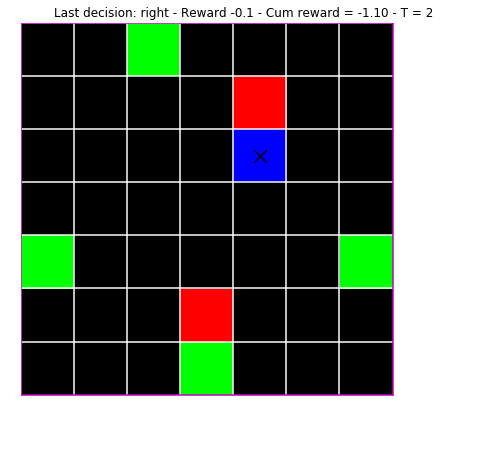

In [28]:
s = next(environment_demo)

# DEBUGGING on a toy example

### The DQN agent class - Random moves with random weights

Just to check that everything works fine...

#### Defining the environment / deep net / experience buffer

In [16]:
epsilon = 0. # Fully stochastic
gamma= 0.95
T = 10

# Environment
environment = dqn.GridWorld(3, 3, 2, 1, T, gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, 1)

#### The DQN agent

In [17]:
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, 1, epsilon=epsilon, gamma=gamma)

#### Press Ctrl + Enter to make the agent move...

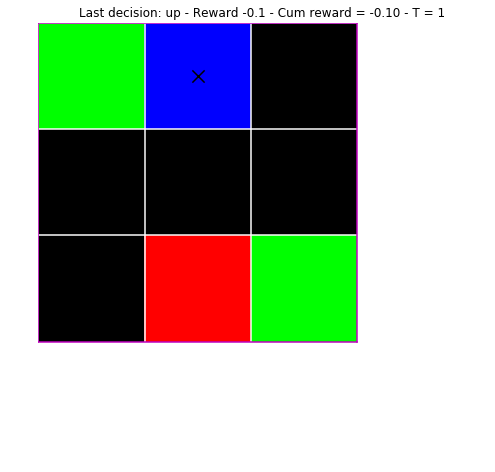

In [34]:
batch, target_batch =  agent.demo()

# Few small experiments on this 3x3 grid

**Nothing to do with POMDPs and DRQNs...** Before experimenting a POMDP and a bigger grid, I wanted to debug/test few things:

- Adam vs SGD
- TargetNet patience = 1 episode vs TargetNet patience = 5 episodes
- Dueling vs No Dueling

**A very small neural net :** 1 hidden layer with 16 neurons and ReLu activation, followed by the linear output layer.

In [29]:
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
neuralnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 3, 3)       0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 1, 1)      448         input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16, 1, 1)      0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 4, 1, 1)       68          activation_1[0][0]               
___________________________________________________________________________________________

### Fixed parameters

In [53]:
epsilon = 0.8 # for epsilon-greedy action selection
gamma= 0.99 # discount factor
batch_size = 32 # nb of samples taken from the experience buffer at each iteration
T = 50 # length of an episode
buffer_size = T*500 # buffer of 500 episodes

### SGD vs Adam

#### SGD

In [57]:
target_patience = 5
# Environment
environment = dqn.GridWorld(3, 3, 2, 1, T, gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [58]:
name = "sgd"
# Train for 100 epochs of 1500 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_01/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_01/curve_%s.npy"%name)

Episode 2999 - Running cum reward = 5.204 took 0.3s..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#### Adam

In [59]:
target_patience = 5
# Environment
environment = dqn.GridWorld(3, 3, 2, 1, T, gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=True)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=True)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [60]:
name = "adam"
# Train for 75 epochs of 1000 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_01/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_01/curve_%s.npy"%name)

Episode 2998 - Running cum reward = -3.603 took 0.4s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#### Learning curves

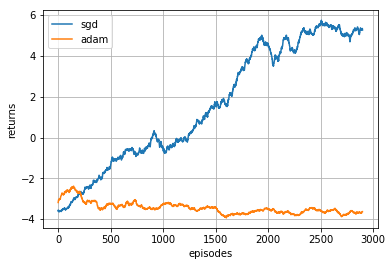

In [34]:
plt.figure()
for name in ["sgd", "adam"]:
    curve = np.load("experiment_01/curve_%s.npy"%name)
    plt.plot(utils.moving_average(curve, 100), label=name)
plt.grid()
plt.legend()
plt.ylabel("returns")
plt.xlabel("episodes")
plt.show()

On this toy example, Adam (=SGD with fancy adaptive learning rate) does not seem to work. I tried to change the learning rate, without success.

### Target patience = 5 vs Target patience = 1

#### Target patience = 1

In [65]:
target_patience = 1
# Environment
environment = dqn.GridWorld(3, 3, 2, 1, T, gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, 50*500)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [ ]:
name = "target_patience=1"
# Train for 75 epochs of 1000 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_01/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_01/curve_%s.npy"%name)

#### Learning curve

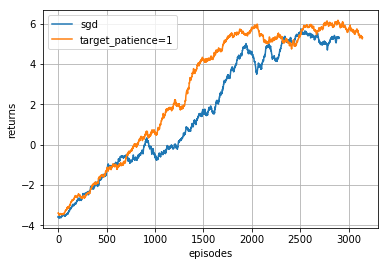

In [35]:
plt.figure()
for name in ["sgd", "target_patience=1"]:
    curve = np.load("experiment_01/curve_%s.npy"%name)
    plt.plot(utils.moving_average(curve, 100), label=name)
plt.grid()
plt.legend()
plt.ylabel("returns")
plt.xlabel("episodes")
plt.show()

Similar performance. I kept using target_patience = 1 in the following.

### Dueling vs No dueling

*Dueling* refers to the decoupling of $Q$ into two estimators : one for the state-value function, one for the "state-action dependent advantage" function:

$$Q(S,A) = V(S) + A(S, A)$$

(see https://arxiv.org/abs/1511.06581)

#### Dueling

In [71]:
target_patience = 1
# Environment
environment = dqn.GridWorld(3, 3, 2, 1, T, gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=True, adam=False)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=True, adam=False)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, 50*500)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [72]:
name = "dueling"
# Train for 75 epochs of 1000 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_01/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_01/curve_%s.npy"%name)

Episode 2999 - Running cum reward = 4.926 took 0.4s..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#### Learning curve

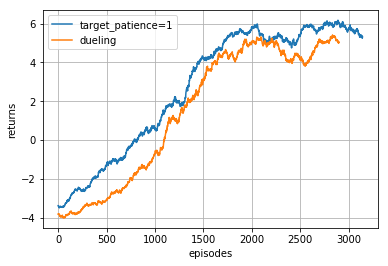

In [36]:
plt.figure()
for name in ["target_patience=1", "dueling"]:
    curve = np.load("experiment_01/curve_%s.npy"%name)
    plt.plot(utils.moving_average(curve, 100), label=name)
plt.grid()
plt.legend()
plt.ylabel("returns")
plt.xlabel("episodes")
plt.show()

I did not use Dueling in the following

### Demo after training

In [357]:
dqn = reload(dqn)

In [358]:
# Environment
environment = dqn.GridWorld(3, 3, 2, 1, T, gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, 50*500)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

#### Load weights

In [359]:
agent.load_weights("experiment_01/weights_sgd.npy")

#### Demo

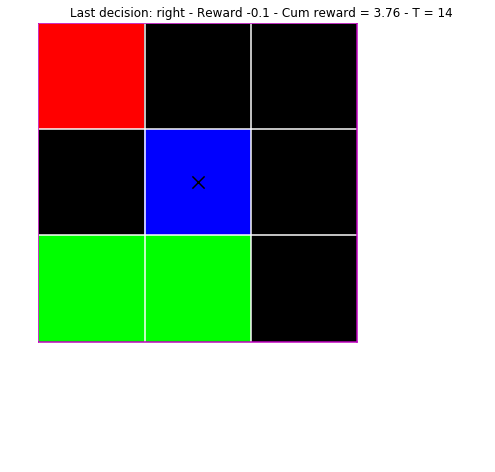

In [497]:
agent.epsilon = 1.
batch, target_batch =  agent.demo()

# Experiment 02 - POMDP - A myopic agent

Let's finally do one experiment with a POMDP.

Here, I consider a 7x7 grid and a **myopic agent**: the agent only sees the 3x3 block of cell centered at its position. Let's compare a DQN and a DRQN on this task.

In [498]:
environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)

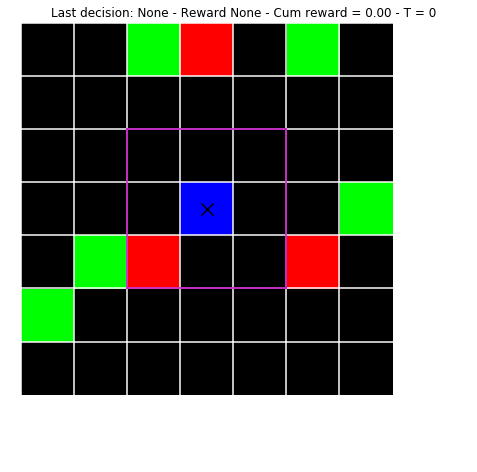

In [68]:
environment.visualize()

### Fixed params

In [500]:
epsilon = 0.8
gamma= 0.99
batch_size = 32
target_patience = 1
buffer_size = 50*500

### DQN

Same neural net as before:

In [30]:
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
neuralnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 3, 3)       0                                            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 16, 1, 1)      448         input_2[0][0]                    
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 16, 1, 1)      0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 4, 1, 1)       68          activation_2[0][0]               
___________________________________________________________________________________________

In [502]:
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [503]:
name = "DQN"
# Train for 100 epochs of 1500 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_02/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_02/curve_%s.npy"%name)

Episode 2999 - Running cum reward = -2.202 took 0.3s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

### DRQN

Our recurrent net: 1 LSTM layer + Output layer

In [33]:
neuralnet = deepnets.RCNN_3x3((batch_size, 1, 27), 0.01)
neuralnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (32, 1, 27)           0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (32, 1, 16)           2816        input_3[0][0]                    
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribut (32, 1, 4)            68          lstm_1[0][0]                     
Total params: 2,884
Trainable params: 2,884
Non-trainable params: 0
____________________________________________________________________________________________________


In [576]:
rec_depth = 50
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)
# A neural net
neuralnet = deepnets.RCNN_3x3((batch_size, 1, 27), 0.01)
neuralnet_copy = deepnets.RCNN_3x3((batch_size, 1, 27), 0.01)
targetnet = deepnets.RCNN_3x3((batch_size, 1, 27), 0.01)
# ExperienceReplay 
experience_replay = dqn.TemporalExperienceReplay(rec_depth, environment.return_state().shape, buffer_size)
# Agent
agent = dqn.StatefulRDQNAgent(environment, neuralnet, neuralnet_copy, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [578]:
name = "DRQN"
# Train for 100 epochs of 1500 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_02/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_02/curve_%s.npy"%name)

Episode 2998 - Running cum reward = -0.897 took 3.4s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

**Note**: I'm pretty sure that my DRQN implementation is not optimal in terms of speed... $10\times$ slower in comparison with my DQN code. I'll investigate this.

## DQN vs DRQN

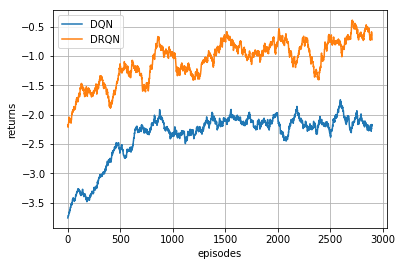

In [37]:
plt.figure()
for name in ["DQN", "DRQN"]:
    curve = np.load("experiment_02/curve_%s.npy"%name)
    plt.plot(utils.moving_average(curve, 100), label=name)
plt.grid()
plt.legend()
plt.ylabel("returns")
plt.xlabel("episodes")
plt.show()

As can be seen on the learning curves, the **Recurrent agent clearly outperforms the feedforward one.** To understand why, let's observe how both agent evolves on this task:

### Live demo

In [596]:
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
DQN = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)
# Load weights
DQN.load_weights("experiment_02/weights_DQN.npy")

# Environment
r_environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)
# A neural net
r_neuralnet = deepnets.RCNN_3x3((batch_size, 1, 27), 0.01)
r_neuralnet_copy = deepnets.RCNN_3x3((batch_size, 1, 27), 0.01)
r_targetnet = deepnets.RCNN_3x3((batch_size, 1, 27), 0.01)
# ExperienceReplay 
t_experience_replay = dqn.TemporalExperienceReplay(rec_depth, environment.return_state().shape, buffer_size)
# Agent
DRQN = dqn.StatefulRDQNAgent(r_environment, r_neuralnet, r_neuralnet_copy, t_experience_replay, batch_size, target_net=r_targetnet, 
                              target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)
DRQN.load_weights("experiment_02/weights_DRQN.npy")

Left: DQN 							Right: DRQN


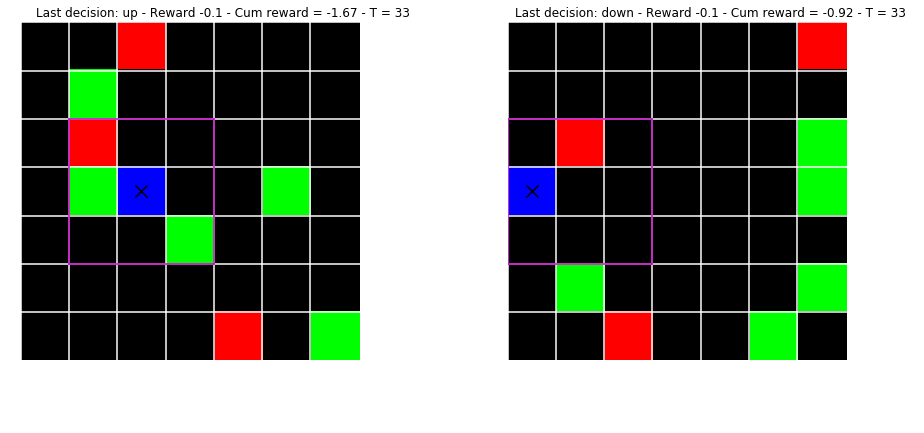

In [1029]:
DQN.epsilon = 1.
DRQN.epsilon = 1.

print("Left: DQN \t\t\t\t\t\t\tRight: DRQN")
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
batch, target_batch =  DQN.demo(fig=False)
plt.subplot(1,2,2)
batch, target_batch =  DRQN.demo(fig=False)
plt.show()

If you manage to execute the cell above, you'll see that the DQN agent gets often stuck in an infinite loop "left-right-left-right..." (or "up-down-up-down...") when there is no green cell among the visible states. On the contrary, as the DRQN agent is able to remember its past actions, this situation occurs less often with the recurrent agent who is better at discovering green cell in unvisited parts of the grid.